<a href="https://colab.research.google.com/github/GuilhermeFreire-Dev/risco-credito-ml-tcc/blob/main/TCC_risco_de_credito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Descrição dos campos
0. Idade
1. Rendimento anual
2. Propriedade de casa própria
3. Duração do emprego (em anos)
4. Intenção de empréstimo
5. Grau do empréstimo
6. Montante do empréstimo
7. Taxa de juro
8. Status do empréstimo (0 não é inadimplente, 1 é inadimplente)
9. Renda percentual
10. Inadimplência histórica
11. Comprimento do histórico de crédito

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours as ENN
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [2]:
credit = pd.read_csv('drive/MyDrive/Data/credit_risk_dataset.csv')

## Análise dos dataset

In [3]:
credit.head(5)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [4]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [5]:
credit.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


Transformando a variável cb_person_default_on_file em um tipo que possa ser melhor trabalhado

In [6]:
le = LabelEncoder()
le.fit(credit.cb_person_default_on_file)
credit.cb_person_default_on_file = le.transform(credit.cb_person_default_on_file)
credit.head(5)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,1,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,0,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,0,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,0,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,1,4


Analisando a variável person_home_ownership

In [7]:
credit.person_home_ownership.value_counts()

,count
person_home_ownership,
RENT,16446
MORTGAGE,13444
OWN,2584
OTHER,107


In [8]:
enc_home_owner = OneHotEncoder(handle_unknown='ignore')
enc_home_owner.fit(credit[['person_home_ownership']])

person_home_ownership = pd.DataFrame(
  enc_home_owner.transform(credit[['person_home_ownership']]).toarray(),
  columns=enc_home_owner.get_feature_names_out(),
  dtype='int32'
)

person_home_ownership.head(5)

,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT
0,0,0,0,1
1,0,0,1,0
2,1,0,0,0
3,0,0,0,1
4,0,0,0,1


Concatenando as novas colunas na base de dados original

In [9]:
credit = pd.concat([credit,person_home_ownership], axis=1)
credit.drop('person_home_ownership', axis=1, inplace=True)
credit.head(5)

,person_age,person_income,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT
0,22,59000,123.0,PERSONAL,D,35000,16.02,1,0.59,1,3,0,0,0,1
1,21,9600,5.0,EDUCATION,B,1000,11.14,0,0.10,0,2,0,0,1,0
2,25,9600,1.0,MEDICAL,C,5500,12.87,1,0.57,0,3,1,0,0,0
3,23,65500,4.0,MEDICAL,C,35000,15.23,1,0.53,0,2,0,0,0,1
4,24,54400,8.0,MEDICAL,C,35000,14.27,1,0.55,1,4,0,0,0,1


Analisando a variável loan_intent

In [10]:
credit.loan_intent.value_counts()

,count
loan_intent,
EDUCATION,6453
MEDICAL,6071
VENTURE,5719
PERSONAL,5521
DEBTCONSOLIDATION,5212
HOMEIMPROVEMENT,3605


In [11]:
enc_loan_intent = OneHotEncoder(handle_unknown='ignore')
enc_loan_intent.fit(credit[['loan_intent']])

loan_intent = pd.DataFrame(
  enc_loan_intent.transform(credit[['loan_intent']]).toarray(),
  columns=enc_loan_intent.get_feature_names_out(),
  dtype='int32'
)

loan_intent.head(5)

,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE
0,0,0,0,0,1,0
1,0,1,0,0,0,0
2,0,0,0,1,0,0
3,0,0,0,1,0,0
4,0,0,0,1,0,0


Concatenando as novas colunas na base de dados origina

In [12]:
credit = pd.concat([credit,loan_intent], axis=1)
credit.drop('loan_intent', axis=1, inplace=True)
credit.head(5)

,person_age,person_income,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE
0,22,59000,123.0,D,35000,16.02,1,0.59,1,3,0,0,0,1,0,0,0,0,1,0
1,21,9600,5.0,B,1000,11.14,0,0.10,0,2,0,0,1,0,0,1,0,0,0,0
2,25,9600,1.0,C,5500,12.87,1,0.57,0,3,1,0,0,0,0,0,0,1,0,0
3,23,65500,4.0,C,35000,15.23,1,0.53,0,2,0,0,0,1,0,0,0,1,0,0
4,24,54400,8.0,C,35000,14.27,1,0.55,1,4,0,0,0,1,0,0,0,1,0,0


Analisando a variável loan_grade
* Indica a qualidade do histórico de crédito e consequente grau de risco
* **A** Indica uma boa qualidade do histórico de crédito e baixo risco
* **G** Indica uma qualidade ruim do histórico de crédito e um alto risco

In [13]:
credit.loan_grade.value_counts()

,count
loan_grade,
A,10777
B,10451
C,6458
D,3626
E,964
F,241
G,64


In [14]:
enc_loan_grade = OrdinalEncoder()
enc_loan_grade.fit(credit[['loan_grade']])
credit['loan_grade'] = enc_loan_grade.transform(credit[['loan_grade']])

credit.head(5)

,person_age,person_income,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE
0,22,59000,123.0,3.0,35000,16.02,1,0.59,1,3,0,0,0,1,0,0,0,0,1,0
1,21,9600,5.0,1.0,1000,11.14,0,0.10,0,2,0,0,1,0,0,1,0,0,0,0
2,25,9600,1.0,2.0,5500,12.87,1,0.57,0,3,1,0,0,0,0,0,0,1,0,0
3,23,65500,4.0,2.0,35000,15.23,1,0.53,0,2,0,0,0,1,0,0,0,1,0,0
4,24,54400,8.0,2.0,35000,14.27,1,0.55,1,4,0,0,0,1,0,0,0,1,0,0


In [15]:
credit.person_age.describe()

,person_age
count,32581.000000
mean,27.734600
std,6.348078
min,20.000000
25%,23.000000
50%,26.000000
75%,30.000000
max,144.000000


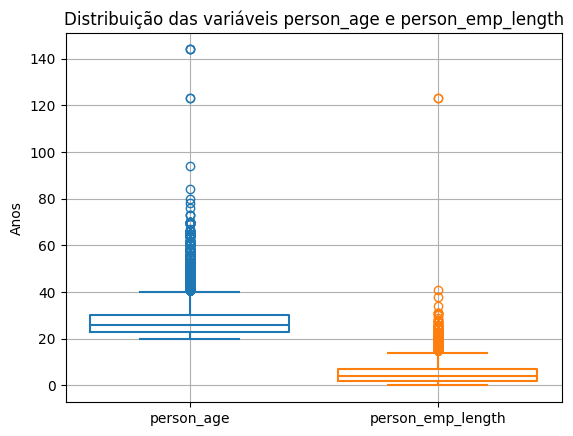

In [16]:
boxplot_data = pd.DataFrame({
    'person_age': credit['person_age'],
    'person_emp_length': credit['person_emp_length'],
})
sns.boxplot(data=boxplot_data, fill=False)

plt.title('Distribuição das variáveis person_age e person_emp_length')
plt.ylabel('Anos')
plt.grid(True)
plt.show()

Identificado a presença de outliers na série que não fazem sentido como idades muito acima de 100.

In [17]:
age_mean = credit.person_age.mean()
credit.loc[credit['person_age'] > 100, 'person_age'] = age_mean
credit.person_age.describe()

<ipython-input-17-13f56b16b69b>:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '27.73459992019889' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  credit.loc[credit['person_age'] > 100, 'person_age'] = age_mean


,person_age
count,32581.000000
mean,27.718046
std,6.204513
min,20.000000
25%,23.000000
50%,26.000000
75%,30.000000
max,94.000000


Analisando a coluna de tempo de emprego

In [18]:
credit.person_emp_length.describe()

,person_emp_length
count,31686.000000
mean,4.789686
std,4.142630
min,0.000000
25%,2.000000
50%,4.000000
75%,7.000000
max,123.000000


<Axes: ylabel='person_emp_length'>

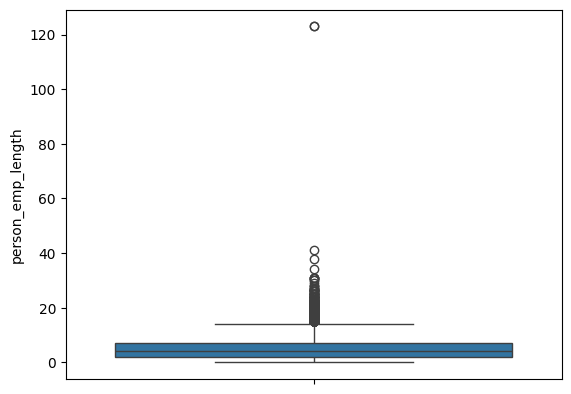

In [19]:
sns.boxplot(credit.person_emp_length)

Nesse caso a variável de quantidade de anos no emprego apresenta outliers que precisam ser tratados

In [20]:
emp_length_mean = credit.person_emp_length.mean()
credit.loc[credit['person_emp_length'] > 50, 'person_emp_length'] = emp_length_mean
credit.person_emp_length.describe()

,person_emp_length
count,31686.000000
mean,4.782225
std,4.034760
min,0.000000
25%,2.000000
50%,4.000000
75%,7.000000
max,41.000000


Analisando dataset para verificar a presença de dados ausentes

In [21]:
credit.isnull().sum()

,0
person_age,0
person_income,0
person_emp_length,895
loan_grade,0
loan_amnt,0
loan_int_rate,3116
loan_status,0
loan_percent_income,0
cb_person_default_on_file,0
cb_person_cred_hist_length,0


In [22]:
credit.shape

(32581, 20)

Proporção dos valores nulos

In [23]:
dataset_size = credit.shape[0]

# Percentual de dados ausentes em person_emp_length
(credit.person_emp_length.isnull().sum() / dataset_size) * 100

2.7469997851508547

In [24]:
# Percentual de dados ausentes em loan_int_rate
(credit.loan_int_rate.isnull().sum() / dataset_size) * 100

9.563856235229121

In [25]:
# Média de person_emp_length
emp_length_mean = credit.person_emp_length.mean()
emp_length_mean

4.782224937593687

In [26]:
# Preenchendo dados ausentes em person_emp_length pela média
credit.person_emp_length.fillna(emp_length_mean, inplace=True)
credit.isnull().sum()

<ipython-input-26-3fe4cea7fe20>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  credit.person_emp_length.fillna(emp_length_mean, inplace=True)


,0
person_age,0
person_income,0
person_emp_length,0
loan_grade,0
loan_amnt,0
loan_int_rate,3116
loan_status,0
loan_percent_income,0
cb_person_default_on_file,0
cb_person_cred_hist_length,0


In [27]:
# Média de loan_int_rate
loan_rate_mean = credit.loan_int_rate.mean()
loan_rate_mean

11.011694892245036

In [28]:
# Preenchendo dados ausentes em loan_int_rate pela média
credit.loan_int_rate.fillna(loan_rate_mean, inplace=True)
credit.isnull().sum()

<ipython-input-28-e2dfd36fa2d6>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  credit.loan_int_rate.fillna(loan_rate_mean, inplace=True)


,0
person_age,0
person_income,0
person_emp_length,0
loan_grade,0
loan_amnt,0
loan_int_rate,0
loan_status,0
loan_percent_income,0
cb_person_default_on_file,0
cb_person_cred_hist_length,0


Base de dados tratada e sem dados ausentes

## Preparando o dataset para treino

Separando a variável alvo do dataset para iniciar o treinamento do modelo

In [29]:
X = credit.drop('loan_status', axis=1)
y = credit.loan_status

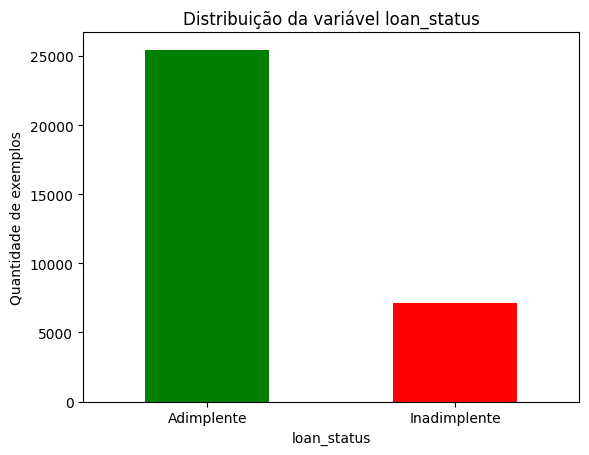

In [30]:
loan_status = y.value_counts()
loan_status.plot(kind='bar', color=['green', 'red'])

plt.title('Distribuição da variável loan_status')
plt.xlabel('loan_status')
plt.ylabel('Quantidade de exemplos')
plt.xticks([0, 1], ['Adimplente', 'Inadimplente'], rotation=0)

plt.show()

Separando os dados em treino e teste

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Balanceamento

Redimensionando os dados de treino

In [32]:
smote = SMOTE(random_state=42)
X_ovs, y_ovs = smote.fit_resample(X_train, y_train)

In [33]:
enn = ENN()
X_uds, y_uds = enn.fit_resample(X_train, y_train)

Visualizando graficamente os dados de treino redimensionandos

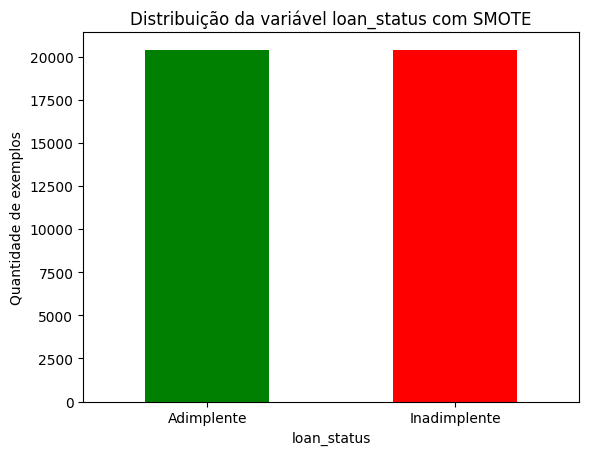

In [34]:
y_balanced = y_ovs.value_counts()
y_balanced.plot(kind='bar', color=['green', 'red'])

plt.title('Distribuição da variável loan_status com SMOTE')
plt.xlabel('loan_status')
plt.ylabel('Quantidade de exemplos')
plt.xticks([0, 1], ['Adimplente', 'Inadimplente'], rotation=0)

plt.show()

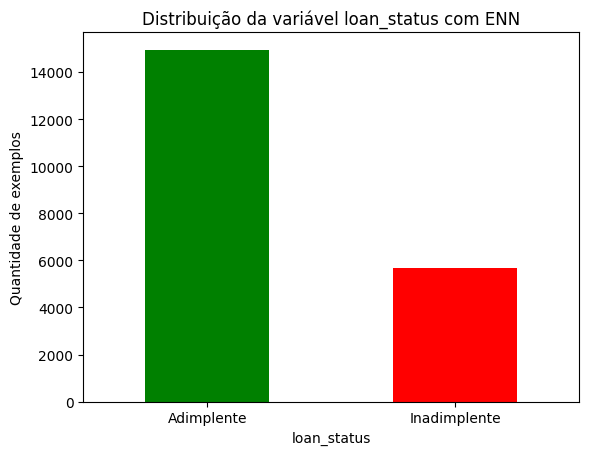

In [35]:
y_balanced = y_uds.value_counts()
y_balanced.plot(kind='bar', color=['green', 'red'])

plt.title('Distribuição da variável loan_status com ENN')
plt.xlabel('loan_status')
plt.ylabel('Quantidade de exemplos')
plt.xticks([0, 1], ['Adimplente', 'Inadimplente'], rotation=0)

plt.show()

## Aplicação dos algoritmos

In [36]:
metrics = ['accuracy', 'recall', 'precision', 'f1']
kf = KFold(n_splits=5, shuffle=True, random_state=42)
general_results = {
    'metrica': ['acuracia', 'recall', 'precisao', 'f1_score'],
    'knn_smote': [],
    'knn_enn': [],
    'raf_smote': [],
    'raf_enn': [],
    'xgb_smote': [],
    'xgb_enn': []
}

### KNN

In [37]:
knn_clf = KNeighborsClassifier()

#### SMOTE

In [38]:
imba_pipeline_knn_smote = make_pipeline(smote, knn_clf)
results = cross_validate(imba_pipeline_knn_smote, X_train, y_train, cv=kf, scoring=metrics)
results = pd.DataFrame(results).mean()
general_results['knn_smote'] = [
    results['test_accuracy'],
    results['test_recall'],
    results['test_precision'],
    results['test_f1']]
results

,0
fit_time,0.214068
score_time,1.695211
test_accuracy,0.771793
test_recall,0.662995
test_precision,0.481914
test_f1,0.557958


#### ENN

In [39]:
imba_pipeline_knn_enn = make_pipeline(enn, knn_clf)
results = cross_validate(imba_pipeline_knn_enn, X_train, y_train, cv=kf, scoring=metrics)
results = pd.DataFrame(results).mean()
general_results['knn_enn'] = [
    results['test_accuracy'],
    results['test_recall'],
    results['test_precision'],
    results['test_f1']]
results

,0
fit_time,2.449585
score_time,0.907513
test_accuracy,0.789595
test_recall,0.665315
test_precision,0.512150
test_f1,0.578672


### Random Forest

In [40]:
raf_clf = RandomForestClassifier(random_state=42)

#### SMOTE

In [41]:
imba_pipeline_raf_smote = make_pipeline(smote, raf_clf)
results = cross_validate(imba_pipeline_raf_smote, X_train, y_train, cv=kf, scoring=metrics)
results = pd.DataFrame(results).mean()
general_results['raf_smote'] = [
    results['test_accuracy'],
    results['test_recall'],
    results['test_precision'],
    results['test_f1']]
results

,0
fit_time,5.350360
score_time,0.124828
test_accuracy,0.932435
test_recall,0.719926
test_precision,0.958102
test_f1,0.822080


#### ENN

In [42]:
imba_pipeline_raf_enn = make_pipeline(enn, raf_clf)
results = cross_validate(imba_pipeline_raf_enn, X_train, y_train, cv=kf, scoring=metrics)
results = pd.DataFrame(results).mean()
general_results['raf_enn'] = [
    results['test_accuracy'],
    results['test_recall'],
    results['test_precision'],
    results['test_f1']]
results

,0
fit_time,4.541648
score_time,0.108520
test_accuracy,0.909837
test_recall,0.754817
test_precision,0.815955
test_f1,0.784192


### XG Boost

In [43]:
xgb_clf = XGBClassifier(enable_categorical=True, device="cpu")

#### SMOTE

In [44]:
imba_pipeline_xgb_smote = make_pipeline(smote, xgb_clf)
results = cross_validate(imba_pipeline_xgb_smote, X_train, y_train, cv=kf, scoring=metrics)
results = pd.DataFrame(results).mean()
general_results['xgb_smote'] = [
    results['test_accuracy'],
    results['test_recall'],
    results['test_precision'],
    results['test_f1']]
results

,0
fit_time,1.123918
score_time,0.051181
test_accuracy,0.933970
test_recall,0.739235
test_precision,0.944517
test_f1,0.829277


#### ENN

In [45]:
imba_pipeline_xgb_enn = make_pipeline(enn, xgb_clf)
results = cross_validate(imba_pipeline_xgb_enn, X_train, y_train, cv=kf, scoring=metrics)
results = pd.DataFrame(results).mean()
general_results['xgb_enn'] = [
    results['test_accuracy'],
    results['test_recall'],
    results['test_precision'],
    results['test_f1']]
results

,0
fit_time,2.845833
score_time,0.048281
test_accuracy,0.906000
test_recall,0.801289
test_precision,0.773708
test_f1,0.787228


### Resultado geral

In [46]:
before_optimization = pd.DataFrame(general_results)
before_optimization

,metrica,knn_smote,knn_enn,raf_smote,raf_enn,xgb_smote,xgb_enn
0,acuracia,0.771793,0.789595,0.932435,0.909837,0.933970,0.906000
1,recall,0.662995,0.665315,0.719926,0.754817,0.739235,0.801289
2,precisao,0.481914,0.512150,0.958102,0.815955,0.944517,0.773708
3,f1_score,0.557958,0.578672,0.822080,0.784192,0.829277,0.787228


## Seleção de hiperparâmetros

### KNN

In [47]:
params = {
    "n_neighbors": [5, 10, 20, 50, 100],
    "weights": ['uniform', 'distance'],
}
new_params = {'kneighborsclassifier__' + key: params[key] for key in params}

In [48]:
grid_search_knn = GridSearchCV(
    imba_pipeline_knn_smote,
    new_params,
    cv=kf,
    scoring='recall',
    return_train_score=True
)
grid_search_knn.fit(X_train, y_train);
grid_search_knn.best_params_

{'kneighborsclassifier__n_neighbors': 50,
 'kneighborsclassifier__weights': 'uniform'}

In [49]:
grid_search_knn.best_score_

0.6898316747812883

In [50]:
grid_search_knn = GridSearchCV(
    imba_pipeline_knn_enn,
    new_params,
    cv=kf,
    scoring='recall',
    return_train_score=True
)
grid_search_knn.fit(X_train, y_train);
grid_search_knn.best_params_

{'kneighborsclassifier__n_neighbors': 5,
 'kneighborsclassifier__weights': 'distance'}

In [51]:
grid_search_knn.best_score_

0.729325119785653

### Random Forest

In [52]:
params = {
    "n_estimators": [100, 200, 400, 800],
    "criterion": ['gini', 'entropy']
}
new_params = {'randomforestclassifier__' + key: params[key] for key in params}

In [53]:
grid_search_raf = GridSearchCV(
    imba_pipeline_raf_smote,
    new_params,
    cv=kf,
    scoring='recall',
    return_train_score=True
)

grid_search_raf.fit(X_train, y_train);
grid_search_raf.best_params_

{'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__n_estimators': 100}

In [54]:
grid_search_raf.best_score_

0.7211624887287689

In [55]:
grid_search_raf = GridSearchCV(
    imba_pipeline_raf_enn,
    new_params,
    cv=kf,
    scoring='recall',
    return_train_score=True
)

grid_search_raf.fit(X_train, y_train);
grid_search_raf.best_params_

{'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__n_estimators': 400}

In [56]:
grid_search_raf.best_score_

0.7553455261151669

### XGBoost

In [57]:
params = {
    "max_depth": [3, 6],
    "subsample": [0, 0.5, 1],
    "num_parallel_tree": [1, 2, 3]
}
new_params = {'xgbclassifier__' + key: params[key] for key in params}

In [58]:
grid_search_xgb = GridSearchCV(
    imba_pipeline_xgb_smote,
    new_params,
    cv=kf,
    scoring='recall',
    return_train_score=True
)

grid_search_xgb.fit(X_train, y_train);
grid_search_xgb.best_params_

{'xgbclassifier__max_depth': 6,
 'xgbclassifier__num_parallel_tree': 1,
 'xgbclassifier__subsample': 0.5}

In [59]:
grid_search_xgb.best_score_

0.7455377850435576

In [60]:
grid_search_xgb = GridSearchCV(
    imba_pipeline_xgb_enn,
    new_params,
    cv=kf,
    scoring='recall',
    return_train_score=True
)

grid_search_xgb.fit(X_train, y_train);
grid_search_xgb.best_params_

{'xgbclassifier__max_depth': 6,
 'xgbclassifier__num_parallel_tree': 2,
 'xgbclassifier__subsample': 1}

In [61]:
grid_search_xgb.best_score_

0.8016330963121693

## Executando Modelos Otimizados

In [62]:
optimized_results = {
    'metrica': ['acuracia', 'recall', 'precisao', 'f1_score'],
    'knn_smote': [],
    'knn_enn': [],
    'raf_smote': [],
    'raf_enn': [],
    'xgb_smote': [],
    'xgb_enn': []
}

### KNN

#### SMOTE

In [63]:
knn_clf = KNeighborsClassifier(n_neighbors=50, weights='uniform')
imba_pipeline_knn_smote = make_pipeline(smote, knn_clf)
results = cross_validate(imba_pipeline_knn_smote, X_train, y_train, cv=kf, scoring=metrics)
results = pd.DataFrame(results).mean()
optimized_results['knn_smote'] = [
    results['test_accuracy'],
    results['test_recall'],
    results['test_precision'],
    results['test_f1']]
results

,0
fit_time,0.188772
score_time,1.706954
test_accuracy,0.770910
test_recall,0.689832
test_precision,0.481086
test_f1,0.566723


#### ENN

In [64]:
knn_clf = KNeighborsClassifier(n_neighbors=5, weights='distance')
imba_pipeline_knn_enn = make_pipeline(enn, knn_clf)
results = cross_validate(imba_pipeline_knn_enn, X_train, y_train, cv=kf, scoring=metrics)
results = pd.DataFrame(results).mean()
optimized_results['knn_enn'] = [
    results['test_accuracy'],
    results['test_recall'],
    results['test_precision'],
    results['test_f1']]
results

,0
fit_time,2.519116
score_time,0.622693
test_accuracy,0.764503
test_recall,0.729325
test_precision,0.472882
test_f1,0.573617


### Random Forest

#### SMOTE

In [65]:
raf_clf = RandomForestClassifier(
    random_state=42,
    n_estimators=100,
    criterion='entropy')
imba_pipeline_raf_smote = make_pipeline(smote, raf_clf)
results = cross_validate(imba_pipeline_raf_smote, X_train, y_train, cv=kf, scoring=metrics)
results = pd.DataFrame(results).mean()
optimized_results['raf_smote'] = [
    results['test_accuracy'],
    results['test_recall'],
    results['test_precision'],
    results['test_f1']]
results

,0
fit_time,5.850176
score_time,0.125943
test_accuracy,0.933241
test_recall,0.721162
test_precision,0.961420
test_f1,0.824089


#### ENN

In [66]:
raf_clf = RandomForestClassifier(
    random_state=42,
    n_estimators=400,
    criterion='gini')
imba_pipeline_raf_enn = make_pipeline(enn, raf_clf)
results = cross_validate(imba_pipeline_raf_enn, X_train, y_train, cv=kf, scoring=metrics)
results = pd.DataFrame(results).mean()
optimized_results['raf_enn'] = [
    results['test_accuracy'],
    results['test_recall'],
    results['test_precision'],
    results['test_f1']]
results

,0
fit_time,11.308813
score_time,0.394886
test_accuracy,0.909722
test_recall,0.755346
test_precision,0.815086
test_f1,0.784078


### XG Boost

#### SMOTE

In [67]:
xgb_clf = XGBClassifier(
    enable_categorical=True,
    device="cpu",
    max_depth=6,
    subsample=0.5,
    num_parallel_tree=1)
imba_pipeline_xgb_smote = make_pipeline(smote, xgb_clf)
results = cross_validate(imba_pipeline_xgb_smote, X_train, y_train, cv=kf, scoring=metrics)
results = pd.DataFrame(results).mean()
optimized_results['xgb_smote'] = [
    results['test_accuracy'],
    results['test_recall'],
    results['test_precision'],
    results['test_f1']]
results

,0
fit_time,0.842872
score_time,0.038576
test_accuracy,0.932474
test_recall,0.745538
test_precision,0.929142
test_f1,0.827243


#### ENN

In [68]:
xgb_clf = XGBClassifier(
    enable_categorical=True,
    device="cpu",
    max_depth=6,
    subsample=1,
    num_parallel_tree=2)
imba_pipeline_xgb_enn = make_pipeline(enn, xgb_clf)
results = cross_validate(imba_pipeline_xgb_enn, X_train, y_train, cv=kf, scoring=metrics)
results = pd.DataFrame(results).mean()
optimized_results['xgb_enn'] = [
    results['test_accuracy'],
    results['test_recall'],
    results['test_precision'],
    results['test_f1']]
results

,0
fit_time,3.619497
score_time,0.049620
test_accuracy,0.906269
test_recall,0.801633
test_precision,0.774435
test_f1,0.787768


## Resultados

In [ ]:
def create_graph(labels, data, title, ylabel):
  x = np.arange(len(labels))
  width = 0.2
  multiplier = 0

  fig, ax = plt.subplots(layout='constrained')

  for attribute, measurement in data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

  ax.set_ylim(0, 1)
  ax.set_ylabel(ylabel)
  ax.set_title(title)
  ax.set_xticks(x + 0.1, labels)
  ax.legend(loc='upper left', ncols=2)
  ax.set_ylim(0, 1)

  plt.show()

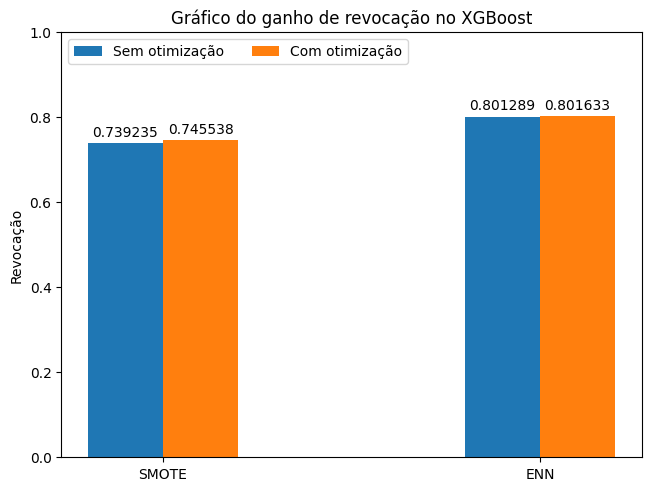

In [ ]:
labels = ('SMOTE', 'ENN')
data = {
  'Sem otimização': (
      general_results['xgb_smote'][1],
      general_results['xgb_enn'][1]),
  'Com otimização': (
      optimized_results['xgb_smote'][1],
      optimized_results['xgb_enn'][1]),
}

create_graph(labels, data, 'Gráfico do ganho de revocação no XGBoost', 'Revocação')

In [ ]:
gain = (general_results['xgb_enn'][1] * 100) / general_results['raf_enn'][1] - 100
round(gain, 2)

6.16

In [ ]:
before_optimization

,metrica,knn_smote,knn_enn,raf_smote,raf_enn,xgb_smote,xgb_enn
0,acuracia,0.771793,0.789595,0.932435,0.909837,0.933970,0.906000
1,recall,0.662995,0.665315,0.719926,0.754817,0.739235,0.801289
2,precisao,0.481914,0.512150,0.958102,0.815955,0.944517,0.773708
3,f1_score,0.557958,0.578672,0.822080,0.784192,0.829277,0.787228


In [ ]:
after_optimization = pd.DataFrame(optimized_results)
after_optimization

,metrica,knn_smote,knn_enn,raf_smote,raf_enn,xgb_smote,xgb_enn
0,acuracia,0.770910,0.764503,0.933241,0.909722,0.932474,0.906269
1,recall,0.689832,0.729325,0.721162,0.755346,0.745538,0.801633
2,precisao,0.481086,0.472882,0.961420,0.815086,0.929142,0.774435
3,f1_score,0.566723,0.573617,0.824089,0.784078,0.827243,0.787768


In [ ]:
optimized_results['metrica'] = ['Acurácia', 'Revocação', 'Precisão', 'F1-Score']

In [ ]:
def show_graph_score(index=0):
  labels = ('KNN', 'Random Forest', 'XGBoost')
  data = {
    'SMOTE': (
        round(optimized_results['knn_smote'][index], 3),
        round(optimized_results['raf_smote'][index], 3),
        round(optimized_results['xgb_smote'][index], 3)),
    'ENN': (
        round(optimized_results['knn_enn'][index], 3),
        round(optimized_results['raf_enn'][index], 3),
        round(optimized_results['xgb_enn'][index], 3)),
  }

  metric = optimized_results['metrica'][index]
  create_graph(labels, data, f'Comparativo de {metric} entre os algoritmos', metric)


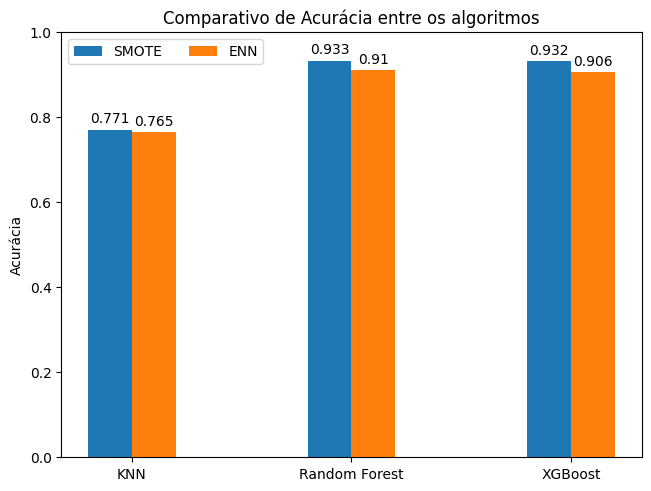

In [ ]:
show_graph_score(0)

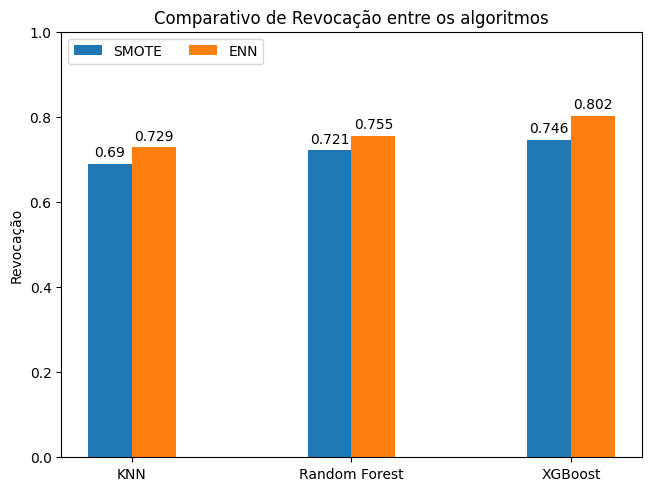

In [ ]:
show_graph_score(1)

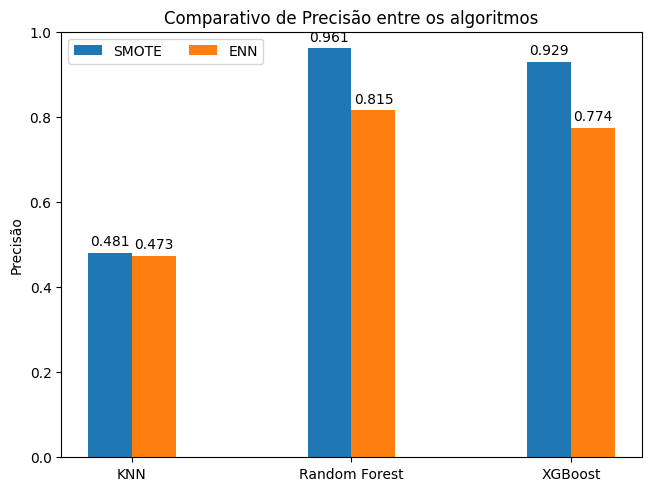

In [ ]:
show_graph_score(2)

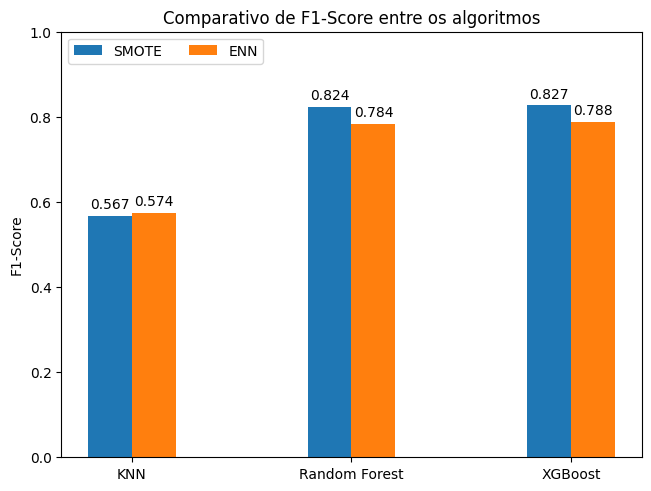

In [ ]:
show_graph_score(3)

## Testando predição

In [69]:
xgb_clf = XGBClassifier(
    enable_categorical=True,
    device="cpu",
    max_depth=6,
    subsample=1,
    num_parallel_tree=2)

xgb_clf.fit(X_uds, y_uds)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cpu', early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=2, random_state=None, ...)

In [70]:
sample = credit.sample(n=10, random_state=1)
sample

,person_age,person_income,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE
29088,27.0,47900,1.0,2.0,7500,13.47,0,0.16,0,6,0,0,1,0,0,0,0,0,0,1
24708,34.0,73000,0.0,1.0,10000,11.11,0,0.14,0,10,0,0,0,1,0,0,0,0,1,0
22316,32.0,54000,16.0,0.0,10000,7.74,0,0.19,0,7,1,0,0,0,0,0,0,1,0,0
15922,23.0,38000,3.0,0.0,19750,7.51,1,0.52,0,4,0,0,0,1,0,0,0,0,1,0
4987,24.0,42996,5.0,0.0,5000,7.14,0,0.12,0,4,0,0,0,1,0,0,0,1,0,0
5690,23.0,45996,7.0,2.0,10000,13.16,0,0.22,0,3,0,0,1,0,0,1,0,0,0,0
21675,29.0,50000,4.0,1.0,21850,12.42,0,0.44,0,10,1,0,0,0,0,0,0,1,0,0
14172,22.0,40000,4.0,1.0,14125,11.49,1,0.35,0,3,0,0,0,1,1,0,0,0,0,0
17603,21.0,18000,1.0,0.0,3200,8.49,1,0.18,0,2,0,0,0,1,0,0,0,0,0,1
1759,21.0,14400,0.0,0.0,2000,5.79,0,0.14,0,2,0,0,0,1,1,0,0,0,0,0


In [71]:
real = sample['loan_status'];
sample.drop('loan_status', axis=1, inplace=True)

In [72]:
for i in range(10):
  pred = xgb_clf.predict(sample.iloc[[i]])
  print(f"Testando predição para a amostra {i + 1}:")
  print(f"valor real: {real.iloc[i]}")
  print(f"valor previsto: {pred[0]}")

Testando predição para a amostra 1:
valor real: 0
valor previsto: 0
Testando predição para a amostra 2:
valor real: 0
valor previsto: 0
Testando predição para a amostra 3:
valor real: 0
valor previsto: 0
Testando predição para a amostra 4:
valor real: 1
valor previsto: 1
Testando predição para a amostra 5:
valor real: 0
valor previsto: 0
Testando predição para a amostra 6:
valor real: 0
valor previsto: 0
Testando predição para a amostra 7:
valor real: 0
valor previsto: 0
Testando predição para a amostra 8:
valor real: 1
valor previsto: 1
Testando predição para a amostra 9:
valor real: 1
valor previsto: 1
Testando predição para a amostra 10:
valor real: 0
valor previsto: 0
